Team Members:\
Aryaman Gokarn(506303588)\
Mugdha Bhagwat(606297799)\
Tania Rajabally(806153219)


# **3. Cora dataset**

## QUESTION 23

In [ ]:
#feel free to use any other library of your choice
!pip install spektral
!pip install Keras
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 kB 1.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import os
import networkx as nx
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from spektral.layers import GCNConv

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
import tensorflow as tf
from tensorflow.keras.regularizers import l2

from collections import Counter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
!ln -s "/gdrive/My Drive/24S_232E/Project2/cora" "/content/cora"

Mounted at /gdrive


In [ ]:
all_data = []
all_edges = []

for root,dirs,files in os.walk('./cora'):
    for file in files:
        if '.content' in file:
            with open(os.path.join(root,file),'r') as f:
                all_data.extend(f.read().splitlines())
        elif 'cites' in file:
            with open(os.path.join(root,file),'r') as f:
                all_edges.extend(f.read().splitlines())



all_data = shuffle(all_data,random_state=42)

In [ ]:
labels = []
nodes = []
X = []

for i,data in enumerate(all_data):
    elements = data.split('\t')
    labels.append(elements[-1])
    X.append(elements[1:-1])
    nodes.append(elements[0])

X = np.array(X,dtype=int)
N = X.shape[0]
F = X.shape[1]
print('X shape: ', X.shape)


#parse the edge
edge_list=[]
for edge in all_edges:
    e = edge.split('\t')
    edge_list.append((e[0],e[1]))

print('\nNumber of nodes (N): ', N)
print('\nNumber of features (F) of each node: ', F)
print('\nCategories: ', set(labels))

num_classes = len(set(labels))
print('\nNumber of classes: ', num_classes)

X shape:  (2708, 1433)

Number of nodes (N):  2708

Number of features (F) of each node:  1433

Categories:  {'Probabilistic_Methods', 'Neural_Networks', 'Genetic_Algorithms', 'Case_Based', 'Rule_Learning', 'Reinforcement_Learning', 'Theory'}

Number of classes:  7


In [ ]:
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edge_list)


A = nx.adjacency_matrix(G)

In [ ]:
print('Graph info: ', (G))

Graph info:  Graph with 2708 nodes and 5278 edges


In the original paper, they picked 20 labeled examples for each class.

Hence, with 7 classes, we will have a total of 140 labeled training examples.

We will also use 500 labeled validation examples and 1000 labeled testing examples.

In [ ]:
def limit_data(labels,limit=20,val_num=500,test_num=1000):
    '''
    Get the index of train, validation, and test data
    '''
    label_counter = dict((l, 0) for l in labels)
    train_idx = []

    for i in range(len(labels)):
        label = labels[i]
        if label_counter[label]<limit:
            #add the example to the training data
            train_idx.append(i)
            label_counter[label]+=1

        #exit the loop once we found 20 examples for each class
        if all(count == limit for count in label_counter.values()):
            break

    #get the indices that do not go to traning data
    rest_idx = [x for x in range(len(labels)) if x not in train_idx]
    val_idx = rest_idx[:val_num]
    test_idx = rest_idx[val_num:(val_num+test_num)]
    return train_idx, val_idx,test_idx

train_idx,val_idx,test_idx = limit_data(labels)

#set the mask
train_mask = np.zeros((N,),dtype=bool)
train_mask[train_idx] = True

val_mask = np.zeros((N,),dtype=bool)
val_mask[val_idx] = True

test_mask = np.zeros((N,),dtype=bool)
test_mask[test_idx] = True

In [ ]:
from sklearn import preprocessing
from keras.utils import to_categorical

def encode_label(labels):
    label_encoder = preprocessing.LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    labels = to_categorical(labels)
    return labels, label_encoder.classes_

labels_encoded, classes = encode_label(labels)

In [ ]:
from spektral.layers import GCNConv
from keras.layers import Input, Dropout
from tensorflow.keras import regularizers
from keras import Model
from keras.optimizers import Adam
import tensorflow as tf
from sklearn.model_selection import ParameterGrid
from keras.callbacks import EarlyStopping
import os

# Define hyperparameters grid
param_grid = {
    'channels': [16, 32, 64, 128],  # Number of channels in the first layer
    'dropout': [0.3, 0.5, 0.7, 0.9],  # Dropout rate for the features
    'l2_reg': [1e-2, 5e-3, 1e-3, 5e-4],  # L2 regularization rate
    'learning_rate': [1e-2, 5e-3, 1e-3, 5e-4],  # Learning rate
}

epochs = 200
es_patience = 10

# Generate all combinations of hyperparameters
grid = ParameterGrid(param_grid)

best_accuracy = 0
best_params = None
best_model = None

for params in grid:
    channels = params['channels']
    dropout = params['dropout']
    l2_reg = params['l2_reg']
    learning_rate = params['learning_rate']

    # Preprocessing operations
    A = GCNConv.preprocess(A).astype('f4')

    # Model definition
    X_in = Input(shape=(F,))
    fltr_in = Input((N,), sparse=True)

    dropout_1 = Dropout(dropout)(X_in)
    graph_conv_1 = GCNConv(channels,
                           activation='relu',
                           kernel_regularizer=regularizers.l2(l2_reg),
                           use_bias=False)([dropout_1, fltr_in])

    dropout_2 = Dropout(dropout)(graph_conv_1)
    graph_conv_2 = GCNConv(num_classes,
                           activation='softmax',
                           use_bias=False)([dropout_2, fltr_in])

    # Build model
    model = Model(inputs=[X_in, fltr_in], outputs=graph_conv_2)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  weighted_metrics=['acc'])

    # Train model
    validation_data = ([X, A], labels_encoded, val_mask)
    history = model.fit([X, A],
                        labels_encoded,
                        sample_weight=train_mask,
                        epochs=epochs,
                        batch_size=N,
                        validation_data=validation_data,
                        shuffle=False,
                        callbacks=[
                            EarlyStopping(patience=es_patience, restore_best_weights=True)
                        ],
                        verbose=0)  # Set verbose to 0 to avoid printing during grid search

    # Get validation accuracy and loss of the 200th epoch
    val_acc = history.history['val_acc'][-1]
    val_loss = history.history['val_loss'][-1]
    acc = history.history['acc'][-1]
    loss = history.history['loss'][-1]

    print('-'*100)
    print("Hyperparameters:", params)
    print("Accuracy:", acc)
    print("Loss:", loss)
    print("Validation Accuracy:", val_acc)
    print("Validation Loss:", val_loss)

    # Check if current model is the best so far
    if val_acc > best_accuracy:
        best_accuracy = val_acc
        best_params = params
        best_model = model

# Save the best model
if best_model is not None:
    model_dir = 'best_model'
    os.makedirs(model_dir, exist_ok=True)
    best_model.save(os.path.join(model_dir, 'best_model.h5'))
    print("Best model saved successfully.")

print("Best validation accuracy:", best_accuracy)
print("Best hyperparameters:", best_params)


----------------------------------------------------------------------------------------------------
Hyperparameters: {'channels': 16, 'dropout': 0.3, 'l2_reg': 0.01, 'learning_rate': 0.01}
Accuracy: 0.9428571462631226
Loss: 0.049838170409202576
Validation Accuracy: 0.7979999780654907
Validation Loss: 0.19460539519786835
----------------------------------------------------------------------------------------------------
Hyperparameters: {'channels': 16, 'dropout': 0.3, 'l2_reg': 0.01, 'learning_rate': 0.005}
Accuracy: 0.9714285731315613
Loss: 0.05914590135216713
Validation Accuracy: 0.722000002861023
Validation Loss: 0.25560635328292847
----------------------------------------------------------------------------------------------------
Hyperparameters: {'channels': 16, 'dropout': 0.3, 'l2_reg': 0.01, 'learning_rate': 0.001}
Accuracy: 0.8785714507102966
Loss: 0.08410657942295074
Validation Accuracy: 0.527999997138977
Validation Loss: 0.3328798711299896
----------------------------------

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
y = labels_encoded

In [ ]:
from sklearn.metrics import classification_report

y_pred = best_model.predict([X, A],batch_size=N)
report = classification_report(np.argmax(y,axis=1), np.argmax(y_pred,axis=1), target_names=classes)
print('GCN Classification Report: \n {}'.format(report))

1/1 [==============================] - 0s 100ms/step
GCN Classification Report: 
                         precision    recall  f1-score   support

            Case_Based       0.64      0.68      0.66       298
    Genetic_Algorithms       0.82      0.83      0.83       418
       Neural_Networks       0.87      0.60      0.71       818
 Probabilistic_Methods       0.70      0.78      0.73       426
Reinforcement_Learning       0.62      0.77      0.68       217
         Rule_Learning       0.57      0.68      0.62       180
                Theory       0.55      0.69      0.61       351

              accuracy                           0.70      2708
             macro avg       0.68      0.72      0.69      2708
          weighted avg       0.73      0.70      0.71      2708



In [ ]:
model = best_model

1/1 [==============================] - 0s 79ms/step


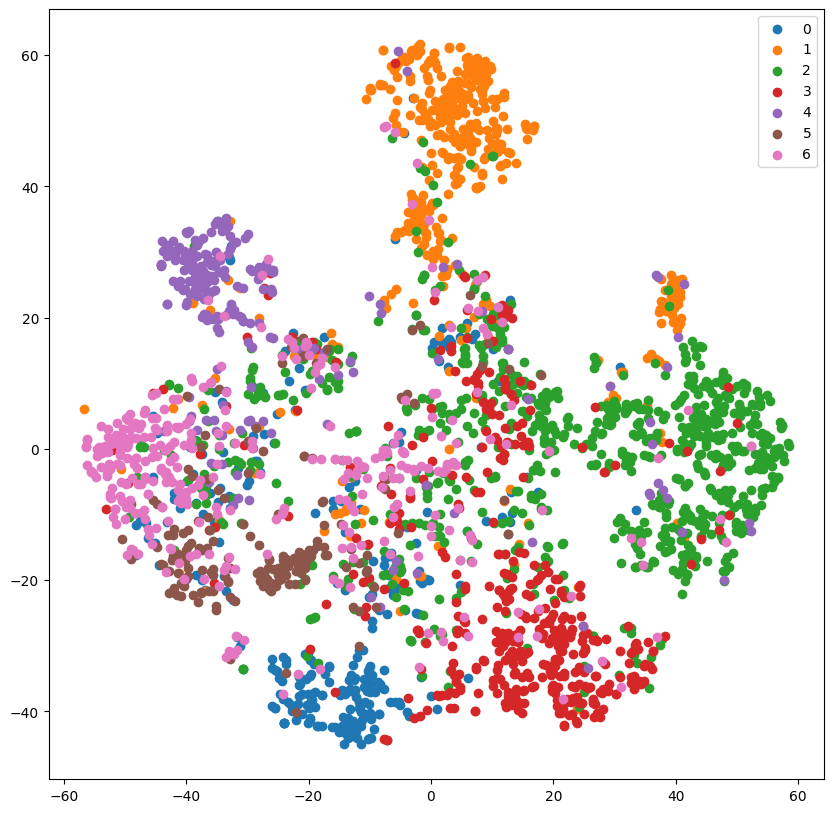

In [ ]:
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict([X,A],batch_size=N)


x_tsne = TSNE(n_components=2).fit_transform(activations[3])

def plot_tSNE(labels_encoded,x_tsne):
    color_map = np.argmax(labels_encoded, axis=1)
    plt.figure(figsize=(10,10))
    for cl in range(num_classes):
        indices = np.where(color_map==cl)
        indices = indices[0]
        plt.scatter(x_tsne[indices,0], x_tsne[indices, 1], label=cl)
    plt.legend()
    plt.show()

plot_tSNE(labels_encoded,x_tsne)

QUESTION 23: Idea 1
Use Graph Convolutional Networks [1]. What hyperparameters do you choose to get the optimal
performance? How many layers did you choose?

> Refer to the graph above. We performed grid search to find the best hyperparameters for a Graph Convolutional Network (GCN) applied to the Cora dataset. The best combination of hyperparameters indicates that a smaller number of channels (16), moderate dropout rate (0.3), moderate L2 regularization (0.01), and a moderate learning rate (0.01) result in the best validation accuracy.

> Best validation accuracy: 0.7979999780654907\
Best hyperparameters: {'channels': 16, 'dropout': 0.3, 'l2_reg': 0.01, 'learning_rate': 0.01}

> In our model we use two layers of GCN with ReLU activation for the first layer and softmax activation for the final layer.


## QUESTION 24

### Node classification with Node2Vec


In [ ]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1 --ignore-requires-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 435.2/435.2 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 531.9/531.9 kB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.1 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score

import os
import networkx as nx
import numpy as np
import pandas as pd

from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph #feel free to use any other library of your choice
from stellargraph import datasets
from IPython.display import display, HTML

%matplotlib inline

In [ ]:
dataset = datasets.Cora()
display(HTML(dataset.description))
G, node_subjects = dataset.load(largest_connected_component_only=True)
print(G.info())


StellarGraph: Undirected multigraph
 Nodes: 2485, Edges: 5209

 Node types:
  paper: [2485]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5209]
        Weights: all 1 (default)
        Features: none


### Corpus generation using random walks

In [ ]:
rw = BiasedRandomWalk(G)

walks = rw.run(
    nodes=list(G.nodes()),  # root nodes
    length=100,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
    q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
)
print("Number of random walks: {}".format(len(walks)))

Number of random walks: 24850


### Representation Learning using Word2Vec

In [ ]:
from gensim.models import Word2Vec

str_walks = [[str(n) for n in walk] for walk in walks]
model = Word2Vec(
    str_walks, vector_size=128, window=5, min_count=0, sg=1, workers=2, epochs=1
)

In [ ]:
# The embedding vectors can be retrieved from model.wv using the node ID as key.
model.wv["19231"].shape

(128,)

### Visualise Node Embeddings

In [ ]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index_to_key  # list of node IDs
node_embeddings = (
    model.wv.vectors
)  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = node_subjects[[int(node_id) for node_id in node_ids]]

In [ ]:
# Apply t-SNE transformation on node embeddings
tsne = TSNE(n_components=2)
node_embeddings_2d = tsne.fit_transform(node_embeddings)

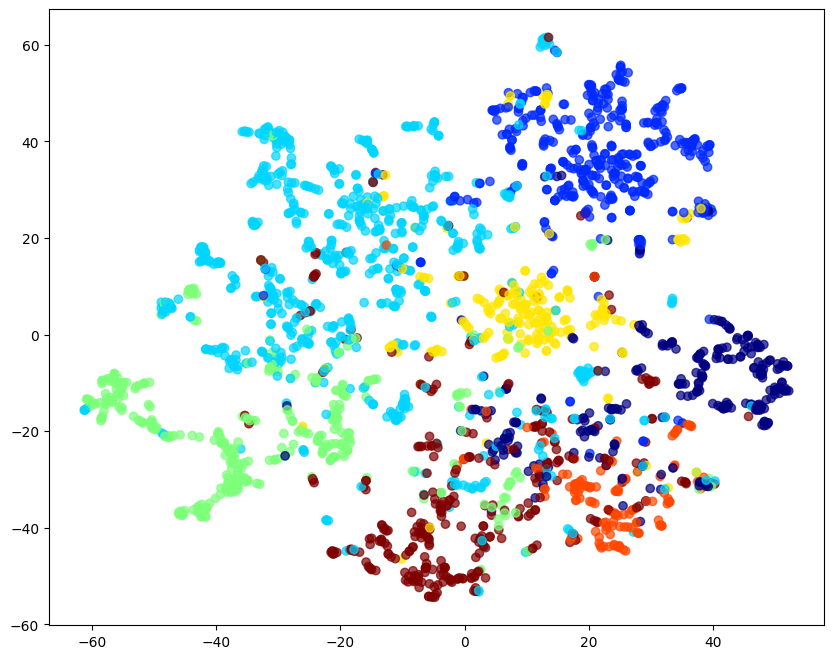

In [ ]:
# draw the points
alpha = 0.7
label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [label_map[target] for target in node_targets]

plt.figure(figsize=(10, 8))
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)

### CORA classification

### Downstream task

The node embeddings calculated using `Word2Vec` can be used as feature vectors in a downstream task such as node attribute inference.


In [ ]:
# X will hold the 128-dimensional input features
X = node_embeddings
# y holds the corresponding target values
y = np.array(node_targets)

In [ ]:
node_targets

35             Genetic_Algorithms
6213       Reinforcement_Learning
1365              Neural_Networks
3229              Neural_Networks
910               Neural_Networks
                    ...          
593248         Genetic_Algorithms
1104495           Neural_Networks
579108         Genetic_Algorithms
416867                     Theory
593201         Genetic_Algorithms
Name: subject, Length: 2485, dtype: object

In [ ]:
X.shape

(2485, 128)

In [ ]:
y.shape

(2485,)

#### Data Splitting

We split the data into train and test sets.

In [ ]:
def limit_data(labels, limit=20, val_num=0, test_num=2345):
    '''
    Get the index of train, validation, and test data
    '''
    label_counter = dict((l, 0) for l in labels)
    train_idx = []

    for i in range(len(labels)):
        label = labels[i]
        if label_counter[label]<limit:
            train_idx.append(i)
            label_counter[label]+=1

        if all(count == limit for count in label_counter.values()):
            break

    rest_idx = [x for x in range(len(labels)) if x not in train_idx]
    val_idx = rest_idx[:val_num]
    test_idx = rest_idx[val_num:(val_num+test_num)]
    return train_idx, val_idx, test_idx

train_idx, val_idx, test_idx = limit_data(np.array(node_targets))

In [ ]:
X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]

In [ ]:
print(
    "Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(
        X_train.shape, y_train.shape, X_test.shape, y_test.shape
    )
)

Array shapes:
 X_train = (140, 128)
 y_train = (140,)
 X_test = (2345, 128)
 y_test = (2345,)


#### Classifier Training

We train a Logistic Regression classifier on the training data.

In [ ]:
clf = LogisticRegressionCV(
    Cs=10, cv=10, scoring="accuracy", verbose=False, multi_class="ovr", max_iter=500
)
clf.fit(X_train, y_train)

LogisticRegressionCV(cv=10, max_iter=500, multi_class='ovr', scoring='accuracy',
                     verbose=False)

Predict the hold out test set.

In [ ]:
y_pred = clf.predict(X_test)

Calculate the accuracy of the classifier on the test set.

In [ ]:
accuracy_score(y_test, y_pred)

0.7176972281449894

In [ ]:
# Print the classification report
print(classification_report(y_test, y_pred))

                        precision    recall  f1-score   support

            Case_Based       0.77      0.72      0.74       265
    Genetic_Algorithms       0.84      0.87      0.85       386
       Neural_Networks       0.81      0.62      0.70       706
 Probabilistic_Methods       0.64      0.80      0.71       359
Reinforcement_Learning       0.64      0.79      0.71       194
         Rule_Learning       0.60      0.73      0.66       111
                Theory       0.60      0.61      0.61       324

              accuracy                           0.72      2345
             macro avg       0.70      0.73      0.71      2345
          weighted avg       0.73      0.72      0.72      2345



#### Classifier Training - SVC


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

svm_classifier = SVC(kernel='rbf')  # You can choose different kernels like 'rbf', 'poly', etc.

# Perform cross-validation on training data
svm_scores = cross_val_score(svm_classifier, X_train, y_train, cv=10)  # You can adjust the number of folds (cv) as needed

print("SVM Cross-Validation Scores:", svm_scores)
print("Mean Accuracy:", svm_scores.mean())

# Fit SVM classifier on the entire training data
svm_classifier.fit(X_train, y_train)

# Evaluate on the test set
svm_test_score = svm_classifier.score(X_test, y_test)
print("Test Accuracy:", svm_test_score)


SVM Cross-Validation Scores: [0.71428571 0.85714286 0.85714286 1.         0.85714286 1.
 0.71428571 0.92857143 0.71428571 0.78571429]
Mean Accuracy: 0.8428571428571429
Test Accuracy: 0.7526652452025586


#### Classifier Training - Neural Network


In [ ]:
from sklearn.neural_network import MLPClassifier

nn_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500)  # You can adjust hidden_layer_sizes and max_iter as needed

# Perform cross-validation on training data
nn_scores = cross_val_score(nn_classifier, X_train, y_train, cv=10)  # You can adjust the number of folds (cv) as needed

print("Neural Network Cross-Validation Scores:", nn_scores)
print("Mean Accuracy:", nn_scores.mean())

# Fit NN classifier on the entire training data
nn_classifier.fit(X_train, y_train)

# Evaluate on the test set
nn_test_score = nn_classifier.score(X_test, y_test)
print("Test Accuracy:", nn_test_score)


Neural Network Cross-Validation Scores: [0.78571429 0.71428571 0.85714286 0.92857143 0.85714286 0.92857143
 0.71428571 0.85714286 0.78571429 0.85714286]
Mean Accuracy: 0.8285714285714285
Test Accuracy: 0.7164179104477612


#### Classifier Training - Random Forest


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=50)  # You can adjust n_estimators and other parameters as needed

# Perform cross-validation on training data
rf_scores = cross_val_score(rf_classifier, X_train, y_train, cv=10)  # You can adjust the number of folds (cv) as needed

print("Random Forest Cross-Validation Scores:", rf_scores)
print("Mean Accuracy:", rf_scores.mean())

# Fit Random Forest classifier on the entire training data
rf_classifier.fit(X_train, y_train)

# Evaluate on the test set
rf_test_score = rf_classifier.score(X_test, y_test)
print("Test Accuracy:", rf_test_score)


Random Forest Cross-Validation Scores: [0.57142857 0.78571429 0.85714286 0.71428571 0.92857143 0.92857143
 0.71428571 0.71428571 0.78571429 0.64285714]
Mean Accuracy: 0.7642857142857143
Test Accuracy: 0.7168443496801705


### Using 1433-dimensional text features (Original X and y)

In [ ]:
X = G.node_features() # Node Embedding from Text Features
y = np.array(node_targets)

X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]

In [ ]:
print(
    "Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(
        X_train.shape, y_train.shape, X_test.shape, y_test.shape
    )
)

Array shapes:
 X_train = (140, 1433)
 y_train = (140,)
 X_test = (2345, 1433)
 y_test = (2345,)


In [ ]:
y_train[0]

'Genetic_Algorithms'

In [ ]:
clf = LogisticRegressionCV(
    Cs=10, cv=10, scoring="accuracy", verbose=False, multi_class="ovr", max_iter=300
)
clf.fit(X_train, y_train)

LogisticRegressionCV(cv=10, max_iter=300, multi_class='ovr', scoring='accuracy',
                     verbose=False)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

0.1275053304904051

#### Classifier Training - SVC


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

svm_classifier = SVC(kernel='rbf')  # You can choose different kernels like 'rbf', 'poly', etc.

# Perform cross-validation on training data
svm_scores = cross_val_score(svm_classifier, X_train, y_train, cv=10)  # You can adjust the number of folds (cv) as needed

print("SVM Cross-Validation Scores:", svm_scores)
print("Mean Accuracy:", svm_scores.mean())

# Fit SVM classifier on the entire training data
svm_classifier.fit(X_train, y_train)

# Evaluate on the test set
svm_test_score = svm_classifier.score(X_test, y_test)
print("Test Accuracy:", svm_test_score)


SVM Cross-Validation Scores: [0.         0.         0.14285714 0.07142857 0.07142857 0.
 0.         0.14285714 0.07142857 0.14285714]
Mean Accuracy: 0.06428571428571428
Test Accuracy: 0.12281449893390192


#### Classifier Training - Neural Network


In [ ]:
from sklearn.neural_network import MLPClassifier

nn_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300)  # You can adjust hidden_layer_sizes and max_iter as needed

# Perform cross-validation on training data
nn_scores = cross_val_score(nn_classifier, X_train, y_train, cv=10)  # You can adjust the number of folds (cv) as needed

print("Neural Network Cross-Validation Scores:", nn_scores)
print("Mean Accuracy:", nn_scores.mean())

# Fit NN classifier on the entire training data
nn_classifier.fit(X_train, y_train)

# Evaluate on the test set
nn_test_score = nn_classifier.score(X_test, y_test)
print("Test Accuracy:", nn_test_score)


Neural Network Cross-Validation Scores: [0.14285714 0.07142857 0.14285714 0.07142857 0.14285714 0.07142857
 0.14285714 0.14285714 0.07142857 0.14285714]
Mean Accuracy: 0.11428571428571428
Test Accuracy: 0.13432835820895522


#### Classifier Training - Random Forest


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=50)  # You can adjust n_estimators

# Perform cross-validation on training data
rf_scores = cross_val_score(rf_classifier, X_train, y_train, cv=10)  # You can adjust the number of folds (cv) as needed

print("Random Forest Cross-Validation Scores:", rf_scores)
print("Mean Accuracy:", rf_scores.mean())

# Fit Random Forest classifier on the entire training data
rf_classifier.fit(X_train, y_train)

# Evaluate on the test set
rf_test_score = rf_classifier.score(X_test, y_test)
print("Test Accuracy:", rf_test_score)


Random Forest Cross-Validation Scores: [0.21428571 0.         0.14285714 0.07142857 0.14285714 0.14285714
 0.07142857 0.21428571 0.14285714 0.21428571]
Mean Accuracy: 0.1357142857142857
Test Accuracy: 0.13603411513859276


### Combined features

In [ ]:
X_combined = np.concatenate((node_embeddings, G.node_features()), axis=1)

X = X_combined
y = np.array(node_targets)

X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]

print(
    "Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(
        X_train.shape, y_train.shape, X_test.shape, y_test.shape
    )
)

Array shapes:
 X_train = (140, 1561)
 y_train = (140,)
 X_test = (2345, 1561)
 y_test = (2345,)


In [ ]:
# Logistic Regression
clf = LogisticRegressionCV(
    Cs=10, cv=10, scoring="accuracy", verbose=False, multi_class="ovr", max_iter=300
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
combined_lr_accuracy = accuracy_score(y_test, y_pred)
print("Logistic Regression Accuracy (Combined Features):", combined_lr_accuracy)

Logistic Regression Accuracy (Combined Features): 0.7121535181236673


#### Classifier Training - SVC


In [ ]:
# SVM
svm_classifier = SVC(kernel="rbf")
svm_scores = cross_val_score(svm_classifier, X_train, y_train, cv=10)
svm_classifier.fit(X_train, y_train)
combined_svm_accuracy = svm_classifier.score(X_test, y_test)
print("SVM Accuracy (Combined Features):", combined_svm_accuracy)


SVM Accuracy (Combined Features): 0.733049040511727


#### Classifier Training - Neural Network


In [ ]:
# Neural Network
nn_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300)
nn_scores = cross_val_score(nn_classifier, X_train, y_train, cv=10)
nn_classifier.fit(X_train, y_train)
combined_nn_accuracy = nn_classifier.score(X_test, y_test)
print("Neural Network Accuracy (Combined Features):", combined_nn_accuracy)

Neural Network Accuracy (Combined Features): 0.6396588486140725


#### Classifier Training - Random Forest


In [ ]:
# Random Forest
rf_classifier = RandomForestClassifier(n_estimators=50)
rf_scores = cross_val_score(rf_classifier, X_train, y_train, cv=10)
rf_classifier.fit(X_train, y_train)
combined_rf_accuracy = rf_classifier.score(X_test, y_test)
print("Random Forest Accuracy (Combined Features):", combined_rf_accuracy)

Random Forest Accuracy (Combined Features): 0.679317697228145


QUESTION 24: Idea 2
Extract structure-based node features using Node2Vec [2]. Briefly describe how Node2Vec finds node features. Choose your desired classifier (one of SVM, Neural Network, or Random Forest) and classify the documents using only Node2Vec (graph structure) features. Now classify the documents using only the 1433-dimensional text features. Which one outperforms? Why do you think this is the case? Combine the Node2Vec and text features and train your classifier on the combined features. What is the best classification accuracy you get (in terms of the percentage of test documents correctly classified)?


**Briefly describe how Node2Vec finds node features**

Node2Vec is an algorithm for feature learning on graphs, particularly useful for capturing structural information in the form of node embeddings. The algorithm is based on the idea of representing nodes as low-dimensional vectors while preserving the graph's structural properties. Here's a brief overview of how Node2Vec works:

1. Random Walks: Node2Vec starts by generating random walks on the graph. A random walk is a sequence of nodes traversed by starting from a given node and repeatedly choosing a neighboring node to visit next. These random walks capture local neighborhood information around each node.

2. Feature Learning: After generating random walks, Node2Vec employs a skip-gram model, similar to Word2Vec, to learn embeddings for each node in the graph. The skip-gram model predicts the context nodes (nodes visited in the random walk) given a target node (starting node of the random walk). By doing so, it learns node embeddings that encode structural similarities between nodes.

3. Optimization: Node2Vec optimizes the embeddings to maximize the likelihood of observing the context nodes given the target node across all random walks.

4. Embedding Extraction: Once the optimization process is complete, Node2Vec extracts the learned embeddings for each node in the graph. These embeddings represent low-dimensional vectors that encode structural information about the nodes and their relationships in the graph.


**Which one outperforms?**

The results confirm that Node2Vec effectively captures structural information from the graph, leading to superior performance compared to using text features alone. The algorithm's ability to learn node embeddings that encode relationships between nodes in the graph contributes significantly to its success in classifying the documents.

**What is the best classification accuracy you get (in terms of the percentage of test documents correctly classified)?**

The best classification accuracy achieved using only Node2Vec features and it is approximately 75.26%. This indicates that the structural information captured by Node2Vec embeddings is effective in classifying the documents, outperforming the classification based solely on text features.

## QUESTION 25

In [ ]:
all_data = []
all_edges = []

for root,dirs,files in os.walk('./cora'):
    for file in files:
        if '.content' in file:
            with open(os.path.join(root,file),'r') as f:
                all_data.extend(f.read().splitlines())
        elif 'cites' in file:
            with open(os.path.join(root,file),'r') as f:
                all_edges.extend(f.read().splitlines())


#random_state = 42
#all_data = shuffle(all_data,random_state=random_state)

In [ ]:
categories =  ['Reinforcement_Learning', 'Theory', 'Case_Based', 'Genetic_Algorithms', 'Probabilistic_Methods', 'Neural_Networks', 'Rule_Learning']
sorted(categories)
label_encoder = {}
i = 0
for cat in sorted(categories):
  label_encoder[cat] = i
  i +=1
label_encoder


{'Case_Based': 0,
 'Genetic_Algorithms': 1,
 'Neural_Networks': 2,
 'Probabilistic_Methods': 3,
 'Reinforcement_Learning': 4,
 'Rule_Learning': 5,
 'Theory': 6}

In [ ]:
#parse the data
labels = []
nodes = []
X = []
element_to_ind  = {}

for i,data in enumerate(all_data):
    elements = data.split('\t')
    labels.append(label_encoder[elements[-1]])
    X.append(elements[1:-1])
    nodes.append(elements[0])
    element_to_ind[elements[0]]= i
X = np.array(X,dtype=int)
N = X.shape[0] #the number of nodes
F = X.shape[1] #the size of node features
print('X shape: ', X.shape)


#parse the edge
edge_list=[]
for edge in all_edges:
    e = edge.split('\t')
    edge_list.append((e[0],e[1]))

print('\nNumber of nodes (N): ', N)
print('\nNumber of features (F) of each node: ', F)
print('\nCategories: ', set(labels))

num_classes = len(set(labels))
print('\nNumber of classes: ', num_classes)


X shape:  (2708, 1433)

Number of nodes (N):  2708

Number of features (F) of each node:  1433

Categories:  {0, 1, 2, 3, 4, 5, 6}

Number of classes:  7


In [ ]:
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edge_list)
G = nx.relabel_nodes(G, element_to_ind)
print('Graph info: ', G)

Graph info:  Graph with 2708 nodes and 5278 edges


In [ ]:
nodes = list(G.nodes)
print(len(nodes))
list(G.neighbors(0))

2708


[258, 544, 8, 435, 14]

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame(list(zip(nodes, labels,X)),columns =['node', 'label','features'])
print(len(df))
df.head()

2708


,node,label,features
0,0,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
2,2,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G = G.subgraph(Gcc[0])
gcc_nodes = list(G.nodes)

In [ ]:
df = df.loc[df['node'].isin(gcc_nodes)]
df['node'] = list(range(len(df))) #rename nodes
df.head()

,node,label,features
0,0,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
2,2,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
train = df.groupby('label', group_keys=False).apply(lambda x: x.sample(20))
G = nx.relabel_nodes(G, df['node'])

In [ ]:
np.array(train.loc[train['node']==1921]['features'])

array([], dtype=object)

In [ ]:
def create_transition_matrix(g):
    vs = list(g.nodes)
    n = len(vs)
    adj = nx.adjacency_matrix(g)
    transition_matrix = adj/adj.sum(axis=1)

    return transition_matrix


In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
def is_numpy_array(arr):
    return isinstance(arr, np.ndarray)

def random_walk(g, num_steps, start_node, transition_matrix=None):
    if transition_matrix is None:
        transition_matrix = create_transition_matrix(g)

    if is_numpy_array(transition_matrix) == True:
      pass
    else:
      # Convert the transition matrix to a dense matrix
      transition_matrix = transition_matrix.todense()

    # Perform a random walk
    current_node = start_node
    for _ in range(num_steps):
        current_node = np.random.choice(list(g.nodes), p=transition_matrix[:, current_node])

    return current_node

In [ ]:
seeds_dict = {predicted:list(train[train['label'] == predicted]['node']) for predicted in range(7)}

def random_walk_with_teleportation(g, num_steps, start_node, tp ,predicted, transition_matrix = None):
  #modify random walk code to add teleportation.
  #you can only teleport to a node belonging to the same class as the start node
  if transition_matrix is None:
    transition_matrix = create_transition_matrix(g)

  if is_numpy_array(transition_matrix) == True:
    pass
  else:
    # Convert the transition matrix to a dense matrix
    transition_matrix = transition_matrix.todense()

  #perform a random walk
  current_node = start_node
  pr = np.zeros(len(list(G.nodes)))
  pr[seeds_dict[predicted]] = 1
  pr /= pr.sum()

  for _ in range(num_steps):
    PMF = transition_matrix[:,current_node]
    PMF = (1-tp) * PMF + tp*pr

    current_node = np.random.choice(list(g.nodes), p=PMF)

  return current_node

### Part (A)

#### Transition Probability = 0

In [ ]:
#pagerank. NO teleportation, NO tfidf.
transition_matrix = create_transition_matrix(G)
transition_matrix = transition_matrix.toarray()

num_samples = 1000
num_walk_steps = 100

visiting_freq_label = []
for i in range(transition_matrix.shape[0]):
  visiting_freq_label.append([0,0,0,0,0,0,0])

visiting_freq = [0 for i in range(transition_matrix.shape[0])]


for j, (train_node,predicted) in enumerate(zip(train['node'],train['label'])):
  print(f'{j}/{len(train["node"])}')

  #print (train_node,predicted)
  for i in range(num_samples):
      start_point = train_node
      end_node = random_walk(G, num_walk_steps, start_point, transition_matrix)
      visiting_freq_label[end_node][predicted] += 1
      visiting_freq[end_node] +=1

0/140
1/140
2/140
3/140
4/140
5/140
6/140
7/140
8/140
9/140
10/140
11/140
12/140
13/140
14/140
15/140
16/140
17/140
18/140
19/140
20/140
21/140
22/140
23/140
24/140
25/140
26/140
27/140
28/140
29/140
30/140
31/140
32/140
33/140
34/140
35/140
36/140
37/140
38/140
39/140
40/140
41/140
42/140
43/140
44/140
45/140
46/140
47/140
48/140
49/140
50/140
51/140
52/140
53/140
54/140
55/140
56/140
57/140
58/140
59/140
60/140
61/140
62/140
63/140
64/140
65/140
66/140
67/140
68/140
69/140
70/140
71/140
72/140
73/140
74/140
75/140
76/140
77/140
78/140
79/140
80/140
81/140
82/140
83/140
84/140
85/140
86/140
87/140
88/140
89/140
90/140
91/140
92/140
93/140
94/140
95/140
96/140
97/140
98/140
99/140
100/140
101/140
102/140
103/140
104/140
105/140
106/140
107/140
108/140
109/140
110/140
111/140
112/140
113/140
114/140
115/140
116/140
117/140
118/140
119/140
120/140
121/140
122/140
123/140
124/140
125/140
126/140
127/140
128/140
129/140
130/140
131/140
132/140
133/140
134/140
135/140
136/140
137/140
138/14

In [ ]:
count = 0 #these many nodes remain unvisited.
for vf in visiting_freq:
  if vf ==0:
    count+=1
print('unvisited = ', count)
visiting_freq_label = np.asarray(visiting_freq_label)
preds = np.argmax(visiting_freq_label,axis = 1)
print(classification_report(df['label'], preds))
accuracy_score(df['label'], preds)

unvisited =  0
              precision    recall  f1-score   support

           0       0.33      0.53      0.41       285
           1       0.50      0.56      0.53       406
           2       0.53      0.30      0.38       726
           3       0.60      0.52      0.56       379
           4       0.09      0.12      0.11       214
           5       0.10      0.23      0.14       131
           6       0.27      0.22      0.24       344

    accuracy                           0.37      2485
   macro avg       0.35      0.35      0.34      2485
weighted avg       0.42      0.37      0.38      2485



0.37183098591549296

#### Transition Probability = 0.1

In [ ]:
#pagerank. WITH telportation, without tfidf

#repeat above expeiment but this time use the teleportation random walk
transition_matrix = create_transition_matrix(G)
transition_matrix = transition_matrix.toarray()

num_samples = 1000
num_walk_steps = 100

visiting_freq_label = []
for i in range(transition_matrix.shape[0]):
  visiting_freq_label.append([0,0,0,0,0,0,0])

visiting_freq = [0 for i in range(transition_matrix.shape[0])]

tp = 0.1
for j, (train_node,predicted) in enumerate(zip(train['node'],train['label'])):
  print(f'{j}/{len(train["node"])}')
  #print (train_node,predicted)
  for i in range(num_samples):
      start_point = train_node
      end_node = random_walk_with_teleportation(G, num_walk_steps, start_point, tp, predicted, transition_matrix)
      visiting_freq_label[end_node][predicted] += 1
      visiting_freq[end_node] +=1

#get metrics
count = 0 #these many nodes remain unvisited.
for vf in visiting_freq:
  if vf ==0:
    count+=1
print('unvisited = ', count)
visiting_freq_label = np.asarray(visiting_freq_label)
preds = np.argmax(visiting_freq_label,axis = 1)
print(classification_report(df['label'], preds))
accuracy_score(df['label'], preds)


0/140
1/140
2/140
3/140
4/140
5/140
6/140
7/140
8/140
9/140
10/140
11/140
12/140
13/140
14/140
15/140
16/140
17/140
18/140
19/140
20/140
21/140
22/140
23/140
24/140
25/140
26/140
27/140
28/140
29/140
30/140
31/140
32/140
33/140
34/140
35/140
36/140
37/140
38/140
39/140
40/140
41/140
42/140
43/140
44/140
45/140
46/140
47/140
48/140
49/140
50/140
51/140
52/140
53/140
54/140
55/140
56/140
57/140
58/140
59/140
60/140
61/140
62/140
63/140
64/140
65/140
66/140
67/140
68/140
69/140
70/140
71/140
72/140
73/140
74/140
75/140
76/140
77/140
78/140
79/140
80/140
81/140
82/140
83/140
84/140
85/140
86/140
87/140
88/140
89/140
90/140
91/140
92/140
93/140
94/140
95/140
96/140
97/140
98/140
99/140
100/140
101/140
102/140
103/140
104/140
105/140
106/140
107/140
108/140
109/140
110/140
111/140
112/140
113/140
114/140
115/140
116/140
117/140
118/140
119/140
120/140
121/140
122/140
123/140
124/140
125/140
126/140
127/140
128/140
129/140
130/140
131/140
132/140
133/140
134/140
135/140
136/140
137/140
138/14

0.7492957746478873

#### Transition Probability = 0.2

In [ ]:
#pagerank. WITH telportation, without tfidf

#repeat above expeiment but this time use the teleportation random walk
transition_matrix = create_transition_matrix(G)
transition_matrix = transition_matrix.toarray()

num_samples = 1000
num_walk_steps = 100

visiting_freq_label = []
for i in range(transition_matrix.shape[0]):
  visiting_freq_label.append([0,0,0,0,0,0,0])

visiting_freq = [0 for i in range(transition_matrix.shape[0])]

tp = 0.2
for j, (train_node,predicted) in enumerate(zip(train['node'],train['label'])):
  print(f'{j}/{len(train["node"])}')
  #print (train_node,predicted)
  for i in range(num_samples):
      start_point = train_node
      end_node = random_walk_with_teleportation(G, num_walk_steps, start_point, tp, predicted, transition_matrix)
      visiting_freq_label[end_node][predicted] += 1
      visiting_freq[end_node] +=1

#get metrics
count = 0 #these many nodes remain unvisited.
for vf in visiting_freq:
  if vf ==0:
    count+=1
print('unvisited = ', count)
visiting_freq_label = np.asarray(visiting_freq_label)
preds = np.argmax(visiting_freq_label,axis = 1)
print(classification_report(df['label'], preds))
accuracy_score(df['label'], preds)


0/140
1/140
2/140
3/140
4/140
5/140
6/140
7/140
8/140
9/140
10/140
11/140
12/140
13/140
14/140
15/140
16/140
17/140
18/140
19/140
20/140
21/140
22/140
23/140
24/140
25/140
26/140
27/140
28/140
29/140
30/140
31/140
32/140
33/140
34/140
35/140
36/140
37/140
38/140
39/140
40/140
41/140
42/140
43/140
44/140
45/140
46/140
47/140
48/140
49/140
50/140
51/140
52/140
53/140
54/140
55/140
56/140
57/140
58/140
59/140
60/140
61/140
62/140
63/140
64/140
65/140
66/140
67/140
68/140
69/140
70/140
71/140
72/140
73/140
74/140
75/140
76/140
77/140
78/140
79/140
80/140
81/140
82/140
83/140
84/140
85/140
86/140
87/140
88/140
89/140
90/140
91/140
92/140
93/140
94/140
95/140
96/140
97/140
98/140
99/140
100/140
101/140
102/140
103/140
104/140
105/140
106/140
107/140
108/140
109/140
110/140
111/140
112/140
113/140
114/140
115/140
116/140
117/140
118/140
119/140
120/140
121/140
122/140
123/140
124/140
125/140
126/140
127/140
128/140
129/140
130/140
131/140
132/140
133/140
134/140
135/140
136/140
137/140
138/14

0.7203219315895373

### Part (B) - With TFIDF

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

vs = list(G.nodes)
n = len(vs)
adj = nx.adjacency_matrix(G)
transition = np.zeros((len(G.nodes), len(G.nodes)))

for n1 in vs:
    for n2 in vs:
        if G.has_edge(n1,n2):
            x1 = np.array(df.loc[df['node']==n1]['features'])[0].reshape(1, -1)
            x2 = np.array(df.loc[df['node']==n2]['features'])[0].reshape(1, -1)
            cos_sim = cosine_similarity(x1, x2)[0][0]  # Extracting the scalar value from the 2D array
            transition[int(n1), int(n2)] = np.exp(cos_sim)

transition /= np.sum(transition, axis=0, keepdims=True)


#### Transition Probability = 0

In [ ]:
#pagerank. Without teleportation. WITH TFIDF
transition_matrix = transition

#perfrom pagerank using our tf_idf based transition matrix
#use randon walk without teleporation
#get metrics
num_samples = 1000
num_walk_steps = 100

visiting_freq_label = []
for i in range(transition_matrix.shape[0]):
  visiting_freq_label.append([0,0,0,0,0,0,0])

visiting_freq = [0 for i in range(transition_matrix.shape[0])]

for j, (train_node,predicted) in enumerate(zip(train['node'],train['label'])):
  print(f'{j}/{len(train["node"])}')
  #print (train_node,predicted)
  for i in range(num_samples):
      start_point = train_node
      end_node = random_walk(G, num_walk_steps, start_point, transition_matrix)
      visiting_freq_label[end_node][predicted] += 1
      visiting_freq[end_node] +=1

#get metrics
count = 0 #these many nodes remain unvisited.
for vf in visiting_freq:
  if vf ==0:
    count+=1
print('unvisited = ', count)
visiting_freq_label = np.asarray(visiting_freq_label)
preds = np.argmax(visiting_freq_label,axis = 1)
print(classification_report(df['label'], preds))
accuracy_score(df['label'], preds)


0/140
1/140
2/140
3/140
4/140
5/140
6/140
7/140
8/140
9/140
10/140
11/140
12/140
13/140
14/140
15/140
16/140
17/140
18/140
19/140
20/140
21/140
22/140
23/140
24/140
25/140
26/140
27/140
28/140
29/140
30/140
31/140
32/140
33/140
34/140
35/140
36/140
37/140
38/140
39/140
40/140
41/140
42/140
43/140
44/140
45/140
46/140
47/140
48/140
49/140
50/140
51/140
52/140
53/140
54/140
55/140
56/140
57/140
58/140
59/140
60/140
61/140
62/140
63/140
64/140
65/140
66/140
67/140
68/140
69/140
70/140
71/140
72/140
73/140
74/140
75/140
76/140
77/140
78/140
79/140
80/140
81/140
82/140
83/140
84/140
85/140
86/140
87/140
88/140
89/140
90/140
91/140
92/140
93/140
94/140
95/140
96/140
97/140
98/140
99/140
100/140
101/140
102/140
103/140
104/140
105/140
106/140
107/140
108/140
109/140
110/140
111/140
112/140
113/140
114/140
115/140
116/140
117/140
118/140
119/140
120/140
121/140
122/140
123/140
124/140
125/140
126/140
127/140
128/140
129/140
130/140
131/140
132/140
133/140
134/140
135/140
136/140
137/140
138/14

0.39476861167002014

#### Transition Probability = 0.1

In [ ]:
#pagerank. WITH teleportation WITH TFIDF
transition_matrix = transition

#same as above, except use random walk with teleportation
#get metrics
num_samples = 1000
num_walk_steps = 100

visiting_freq_label = []
for i in range(transition_matrix.shape[0]):
  visiting_freq_label.append([0,0,0,0,0,0,0])

visiting_freq = [0 for i in range(transition_matrix.shape[0])]

tp = 0.1
for j, (train_node,predicted) in enumerate(zip(train['node'],train['label'])):
  print(f'{j}/{len(train["node"])}')
  #print (train_node,predicted)
  for i in range(num_samples):
      start_point = train_node
      end_node = random_walk_with_teleportation(G, num_walk_steps, start_point, tp, predicted, transition_matrix)
      visiting_freq_label[end_node][predicted] += 1
      visiting_freq[end_node] +=1

#get metrics
count = 0 #these many nodes remain unvisited.
for vf in visiting_freq:
  if vf ==0:
    count+=1
print('unvisited = ', count)
visiting_freq_label = np.asarray(visiting_freq_label)
preds = np.argmax(visiting_freq_label,axis = 1)
print(classification_report(df['label'], preds))
accuracy_score(df['label'], preds)


0/140
1/140
2/140
3/140
4/140
5/140
6/140
7/140
8/140
9/140
10/140
11/140
12/140
13/140
14/140
15/140
16/140
17/140
18/140
19/140
20/140
21/140
22/140
23/140
24/140
25/140
26/140
27/140
28/140
29/140
30/140
31/140
32/140
33/140
34/140
35/140
36/140
37/140
38/140
39/140
40/140
41/140
42/140
43/140
44/140
45/140
46/140
47/140
48/140
49/140
50/140
51/140
52/140
53/140
54/140
55/140
56/140
57/140
58/140
59/140
60/140
61/140
62/140
63/140
64/140
65/140
66/140
67/140
68/140
69/140
70/140
71/140
72/140
73/140
74/140
75/140
76/140
77/140
78/140
79/140
80/140
81/140
82/140
83/140
84/140
85/140
86/140
87/140
88/140
89/140
90/140
91/140
92/140
93/140
94/140
95/140
96/140
97/140
98/140
99/140
100/140
101/140
102/140
103/140
104/140
105/140
106/140
107/140
108/140
109/140
110/140
111/140
112/140
113/140
114/140
115/140
116/140
117/140
118/140
119/140
120/140
121/140
122/140
123/140
124/140
125/140
126/140
127/140
128/140
129/140
130/140
131/140
132/140
133/140
134/140
135/140
136/140
137/140
138/14

0.7553319919517103

#### Transition Probability = 0.2

In [ ]:
#pagerank. WITH teleportation WITH TFIDF
transition_matrix = transition

num_samples = 1000
num_walk_steps = 100

visiting_freq_label = []
for i in range(transition_matrix.shape[0]):
  visiting_freq_label.append([0,0,0,0,0,0,0])

visiting_freq = [0 for i in range(transition_matrix.shape[0])]

tp = 0.2
for j, (train_node,predicted) in enumerate(zip(train['node'],train['label'])):
  print(f'{j}/{len(train["node"])}')
  #print (train_node,predicted)
  for i in range(num_samples):
      start_point = train_node
      end_node = random_walk_with_teleportation(G, num_walk_steps, start_point, tp, predicted, transition_matrix)
      visiting_freq_label[end_node][predicted] += 1
      visiting_freq[end_node] +=1



0/140
1/140
2/140
3/140
4/140
5/140
6/140
7/140
8/140
9/140
10/140
11/140
12/140
13/140
14/140
15/140
16/140
17/140
18/140
19/140
20/140
21/140
22/140
23/140
24/140
25/140
26/140
27/140
28/140
29/140
30/140
31/140
32/140
33/140
34/140
35/140
36/140
37/140
38/140
39/140
40/140
41/140
42/140
43/140
44/140
45/140
46/140
47/140
48/140
49/140
50/140
51/140
52/140
53/140
54/140
55/140
56/140
57/140
58/140
59/140
60/140
61/140
62/140
63/140
64/140
65/140
66/140
67/140
68/140
69/140
70/140
71/140
72/140
73/140
74/140
75/140
76/140
77/140
78/140
79/140
80/140
81/140
82/140
83/140
84/140
85/140
86/140
87/140
88/140
89/140
90/140
91/140
92/140
93/140
94/140
95/140
96/140
97/140
98/140
99/140
100/140
101/140
102/140
103/140
104/140
105/140
106/140
107/140
108/140
109/140
110/140
111/140
112/140
113/140
114/140
115/140
116/140
117/140
118/140
119/140
120/140
121/140
122/140
123/140
124/140
125/140
126/140
127/140
128/140
129/140
130/140
131/140
132/140
133/140
134/140
135/140
136/140
137/140
138/14

In [ ]:
#get metrics
count = 0 #these many nodes remain unvisited.
for vf in visiting_freq:
  if vf ==0:
    count+=1
print('unvisited = ', count)
visiting_freq_label = np.asarray(visiting_freq_label)
preds = np.argmax(visiting_freq_label,axis = 1)
print(classification_report(df['label'], preds))
accuracy_score(df['label'], preds)


unvisited =  61
              precision    recall  f1-score   support

           0       0.60      0.74      0.66       285
           1       0.84      0.90      0.87       406
           2       0.86      0.56      0.68       726
           3       0.78      0.80      0.79       379
           4       0.67      0.83      0.74       214
           5       0.46      0.89      0.60       131
           6       0.64      0.58      0.61       344

    accuracy                           0.72      2485
   macro avg       0.69      0.76      0.71      2485
weighted avg       0.75      0.72      0.72      2485



0.717907444668008